In [ ]:
pip install qiskit-optimization

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 643.4/643.4 kB 10.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.6/167.6 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 76.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.6/308.6 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 62.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 8.0 MB/s eta 0:00:00
  Created wheel for docplex: filename=docplex-2.28.240-py3-none-any.whl size=682834 sha256=53ae2574d83f0a

In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit_algorithms import SamplingVQE, NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import SPSA
from qiskit_algorithms.utils import algorithm_globals
from qiskit.primitives import Sampler
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from itertools import permutations
from qiskit_optimization.converters import QuadraticProgramToQubo

In [ ]:
def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

In [ ]:
def draw_subgraph(G):
  pos = nx.spring_layout(G, seed=500)  # positions for all nodes - seed for reproducibility

  # nodes
  nx.draw_networkx_nodes(G, pos, node_size=100)

  # edges
  nx.draw_networkx_edges(G, pos)

  # node labels
  nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")
  # edge weight labels
  edge_labels = nx.get_edge_attributes(G, "weight")
  nx.draw_networkx_edge_labels(G, pos, edge_labels)

  tsp = Tsp(G) # graph as tsp

  ax = plt.gca()
  ax.margins(0.08)
  plt.axis("off")
  plt.tight_layout()
  plt.show()

In [ ]:

def brute_force_tsp(w, N):
    a = list(permutations(range(1, N)))
    last_best_distance = 1e10
    for i in a:
        distance = 0
        pre_j = 0
        for j in i:
            distance = distance + w[j, pre_j]
            pre_j = j
        distance = distance + w[pre_j, 0]
        order = (0,) + i
        if distance < last_best_distance:
            best_order = order
            last_best_distance = distance
            print("order = " + str(order) + " Distance = " + str(distance))
    return last_best_distance, best_order

def draw_tsp_solution(G, order, colors, pos):
    G2 = nx.DiGraph()
    G2.add_nodes_from(G)
    n = len(order)
    for i in range(n):
        j = (i + 1) % n
        G2.add_edge(order[i], order[j], weight=G[order[i]][order[j]]["weight"])
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(
        G2, node_color=colors, edge_color="b", node_size=600, alpha=0.8, ax=default_axes, pos=pos
    )
    edge_labels = nx.get_edge_attributes(G2, "weight")
    nx.draw_networkx_edge_labels(G2, pos, font_color="b", edge_labels=edge_labels)

In [ ]:
df = pd.read_csv("Квантовый_хакатон_Отборочная_задача.csv")
df = df.replace('-', '1000')
data = df.drop('Location', axis=1).replace('-', 1000).astype(int)
data= data.rename(
    columns={'O': '0', 'A': '1', 'B': '2', 'C': '3', 'D': '4', 'E': '5',
             'F': '6', 'G': '7', 'H': '8', 'I': '9', 'J': '10', 'K': '11',
             'L': '12', 'M': '13', 'N': '14'
    }
    )

display(df)

,Location,O,A,B,C,D,E,F,G,H,I,J,K,L,M,N
0,O,0,15,30,25,40,17,32,1000,28,1000,26,31,42,1000,35
1,A,15,0,8,1000,18,1000,1000,1000,20,1000,11,19,1000,26,1000
2,B,30,8,0,9,16,14,1000,1000,14,1000,1000,1000,23,1000,1000
3,C,25,1000,9,0,1000,21,1000,16,1000,30,1000,33,1000,40,19
4,D,40,18,16,1000,0,1000,22,1000,1000,1000,1000,29,25,38,1000
5,E,17,1000,14,21,1000,0,1000,1000,27,14,1000,27,1000,1000,24
6,F,32,1000,1000,1000,22,1000,0,10,1000,1000,22,26,1000,35,31
7,G,1000,1000,1000,16,1000,1000,10,0,24,17,1000,1000,29,38,1000
8,H,28,20,14,1000,1000,27,1000,24,0,1000,19,1000,1000,29,23
9,I,1000,1000,1000,30,1000,14,1000,17,1000,0,24,30,1000,39,1000


['O', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N']


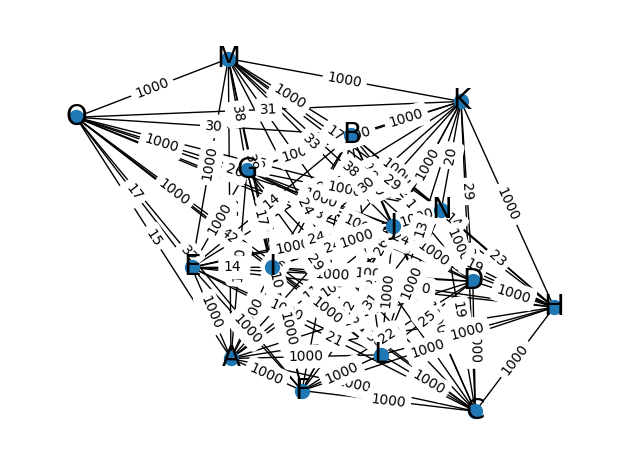

In [ ]:
nodes = df["Location"].to_list()
print(nodes)
G = nx.Graph()
for string in range(0, len(nodes)):
  for column in nodes:
    if df[column][string] != '0':
      G.add_edge(nodes[string], column, weight=int(df[column][string]))

pos = nx.spring_layout(G, seed=500)  # positions for all nodes - seed for reproducibility

# nodes
nx.draw_networkx_nodes(G, pos, node_size=100)

# edges
nx.draw_networkx_edges(G, pos)

# node labels
nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")
# edge weight labels
edge_labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels)

tsp = Tsp(G) # graph as tsp

ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
row1 = [0, 1, 2, 8, 10]
row2 = [3, 5, 9, 11, 14]
row3 = [4, 6, 7, 12, 13]
column1 = ['0', '1', '2', '8', '10']
column2 = ['3', '5', '9', '11', '14']
column3 = ['4', '6', '7', '12', '13']

graf1_row = row2 + row3
graf2_row = row1 + row3
graf3_row = row1 + row2

graf1_column = column2 + column3
graf2_column = column1 + column3
graf3_column = column1 + column2


In [ ]:
df1 = data.drop(graf1_row)
df1 = df1.drop(graf1_column, axis=1)
df1 = df1.rename(
    columns={'8': '3', '10': '4'
    }
    ).reset_index(drop=True)
df2 = data.drop(graf2_row)
df2 = df2.drop(graf2_column, axis=1)
df2 = df2.rename(
    columns={'3': '0', '5': '1', '9': '2', '11': '3', '14': '4'
    }
    ).reset_index(drop=True)
df3 = data.drop(graf3_row)
df3 = df3.drop(graf3_column, axis=1)
df3 = df3.rename(
    columns={'4': '0', '6': '1', '7': '2', '12': '3', '13': '4'
    }
    ).reset_index(drop=True)
display(df1)
display(df2)
df1

,0,1,2,3,4
0,0,15,30,28,26
1,15,0,8,20,11
2,30,8,0,14,1000
3,28,20,14,0,19
4,26,11,1000,19,0


,0,1,2,3,4
0,0,21,30,33,19
1,21,0,14,27,24
2,30,14,0,30,1000
3,33,27,30,0,20
4,19,24,1000,20,0


,0,1,2,3,4
0,0,15,30,28,26
1,15,0,8,20,11
2,30,8,0,14,1000
3,28,20,14,0,19
4,26,11,1000,19,0


In [ ]:
nodes_1 = df1.columns.to_list()
G1 = nx.Graph()
for string in nodes_1:
  for column in nodes_1:
    if df1[column][int(string)] != 0:
      G1.add_edge(int(string), int(column), weight=df1[column][int(string)])

tsp_1 = Tsp(G1)

In [ ]:
G1.has_edge(0, 1)

True

In [ ]:
nodes_2 = df2.columns.to_list()
G2 = nx.Graph()
for string in nodes_2:
  for column in nodes_2:
    if df2[column][int(string)] != 0:
      G2.add_edge(int(string), int(column), weight=df2[column][int(string)])

tsp_2 = Tsp(G2)

In [ ]:
nodes_3 = df3.columns.to_list()
G3 = nx.Graph()
for string in nodes_3:
  for column in nodes_3:
    if df3[column][int(string)] != 0:
      G3.add_edge(int(string), int(column), weight=df3[column][int(string)])

tsp_3 = Tsp(G3)

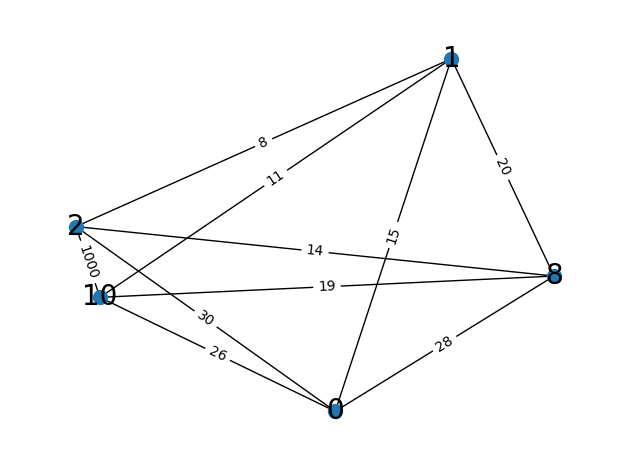

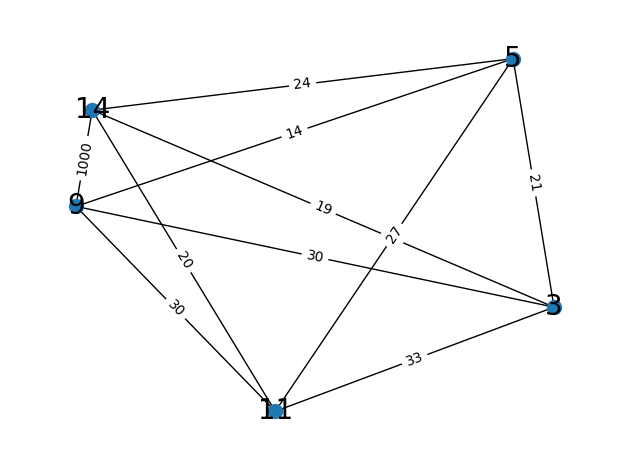

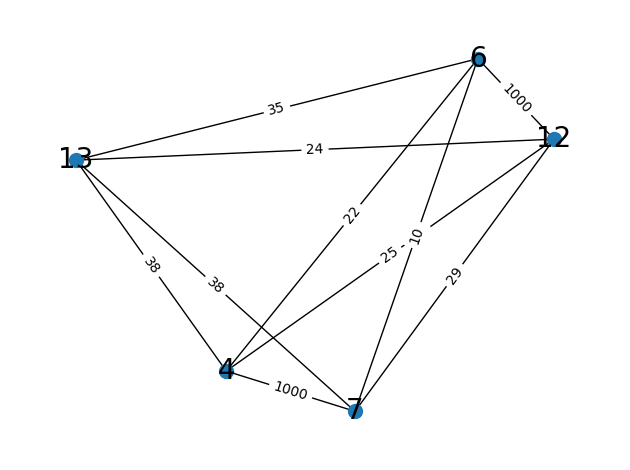

In [ ]:
subgraph_list = [G1, G2, G3]
for i in subgraph_list:
  draw_subgraph(i)

In [ ]:
qp_1 = tsp_1.to_quadratic_program()
print(qp_1.prettyprint())

Problem name: TSP

Minimize
  21*x_0_0*x_1_1 + 21*x_0_0*x_1_4 + 30*x_0_0*x_2_1 + 30*x_0_0*x_2_4
  + 33*x_0_0*x_3_1 + 33*x_0_0*x_3_4 + 19*x_0_0*x_4_1 + 19*x_0_0*x_4_4
  + 21*x_0_1*x_1_0 + 21*x_0_1*x_1_2 + 30*x_0_1*x_2_0 + 30*x_0_1*x_2_2
  + 33*x_0_1*x_3_0 + 33*x_0_1*x_3_2 + 19*x_0_1*x_4_0 + 19*x_0_1*x_4_2
  + 21*x_0_2*x_1_1 + 21*x_0_2*x_1_3 + 30*x_0_2*x_2_1 + 30*x_0_2*x_2_3
  + 33*x_0_2*x_3_1 + 33*x_0_2*x_3_3 + 19*x_0_2*x_4_1 + 19*x_0_2*x_4_3
  + 21*x_0_3*x_1_2 + 21*x_0_3*x_1_4 + 30*x_0_3*x_2_2 + 30*x_0_3*x_2_4
  + 33*x_0_3*x_3_2 + 33*x_0_3*x_3_4 + 19*x_0_3*x_4_2 + 19*x_0_3*x_4_4
  + 21*x_0_4*x_1_0 + 21*x_0_4*x_1_3 + 30*x_0_4*x_2_0 + 30*x_0_4*x_2_3
  + 33*x_0_4*x_3_0 + 33*x_0_4*x_3_3 + 19*x_0_4*x_4_0 + 19*x_0_4*x_4_3
  + 14*x_1_0*x_2_1 + 14*x_1_0*x_2_4 + 27*x_1_0*x_3_1 + 27*x_1_0*x_3_4
  + 24*x_1_0*x_4_1 + 24*x_1_0*x_4_4 + 14*x_1_1*x_2_0 + 14*x_1_1*x_2_2
  + 27*x_1_1*x_3_0 + 27*x_1_1*x_3_2 + 24*x_1_1*x_4_0 + 24*x_1_1*x_4_2
  + 14*x_1_2*x_2_1 + 14*x_1_2*x_2_3 + 27*x_1_2*x_3_1 + 27*x_1_2*

In [ ]:
qp2qubo = QuadraticProgramToQubo()
qubo = qp2qubo.convert(qp_1)
qubitOp, offset = qubo.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

Offset: 412812.5
Ising Hamiltonian:
SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIIIIIIIIIIIIZI', 'IIIIIIIIIIIIIIIIIIIIIIZII', 'IIIIIIIIIIIIIIIIIIIIIZIII', 'IIIIIIIIIIIIIIIIIIIIZIIII', 'IIIIIIIIIIIIIIIIIIIZIIIII', 'IIIIIIIIIIIIIIIIIIZIIIIII', 'IIIIIIIIIIIIIIIIIZIIIIIII', 'IIIIIIIIIIIIIIIIZIIIIIIII', 'IIIIIIIIIIIIIIIZIIIIIIIII', 'IIIIIIIIIIIIIIZIIIIIIIIII', 'IIIIIIIIIIIIIZIIIIIIIIIII', 'IIIIIIIIIIIIZIIIIIIIIIIII', 'IIIIIIIIIIIZIIIIIIIIIIIII', 'IIIIIIIIIIZIIIIIIIIIIIIII', 'IIIIIIIIIZIIIIIIIIIIIIIII', 'IIIIIIIIZIIIIIIIIIIIIIIII', 'IIIIIIIZIIIIIIIIIIIIIIIII', 'IIIIIIZIIIIIIIIIIIIIIIIII', 'IIIIIZIIIIIIIIIIIIIIIIIII', 'IIIIZIIIIIIIIIIIIIIIIIIII', 'IIIZIIIIIIIIIIIIIIIIIIIII', 'IIZIIIIIIIIIIIIIIIIIIIIII', 'IZIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIZZ', 'IIIIIIIIIIIIIIIIIIIIIIZIZ', 'IIIIIIIIIIIIIIIIIIIIIZIIZ', 'IIIIIIIIIIIIIIIIIIIIZIIIZ', 'IIIIIIIIIIIIIIIIIIIZIIIIZ', 'IIIIIIIIIIIIIIIIIIZIIIIIZ', 'IIIIIIIIIIIIIIIZIIIIIIIIZ', 'IIIIIIIIIIIIIIZIIIII

In [ ]:
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
result = exact.solve(qubo)
print(result.prettyprint())

objective function value: 82.0
variable values: x_0_0=0.0, x_0_1=0.0, x_0_2=1.0, x_0_3=0.0, x_0_4=0.0, x_1_0=0.0, x_1_1=0.0, x_1_2=0.0, x_1_3=1.0, x_1_4=0.0, x_2_0=0.0, x_2_1=0.0, x_2_2=0.0, x_2_3=0.0, x_2_4=1.0, x_3_0=1.0, x_3_1=0.0, x_3_2=0.0, x_3_3=0.0, x_3_4=0.0, x_4_0=0.0, x_4_1=1.0, x_4_2=0.0, x_4_3=0.0, x_4_4=0.0
status: SUCCESS


In [ ]:
qp_1 = tsp_1.to_quadratic_program()

qp2qubo = QuadraticProgramToQubo()
qubo_1 = qp2qubo.convert(qp_1)
qubitOp_1, offset_1 = qubo_1.to_ising()

exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
#result_1 = exact.solve(qubo_1)

ee = NumPyMinimumEigensolver()
result_1 = ee.compute_minimum_eigenvalue(qubitOp_1)

x_1 = tsp_1.sample_most_likely(result_1.eigenstate)

z_1 = tsp_1.interpret(x_1)

adj_matrix_1 = nx.to_numpy_array(tsp_1.graph)

print("solution:", z_1)
print("solution objective:", tsp_2.tsp_value(z_1, adj_matrix_1))
colors = ["r" for node in tsp_2.graph.nodes]

#pos_1 = [tsp_1.graph.nodes[node]["pos"] for node in tsp_1.graph.nodes]
#draw_tsp_solution(tsp_2.graph, z_2, colors, pos)

solution: [3, 4, 0, 1, 2]
solution objective: 82.0


solution: [3, 4, 0, 1, 2]
solution objective: 104.0


NetworkXError: Node 0 has no position.

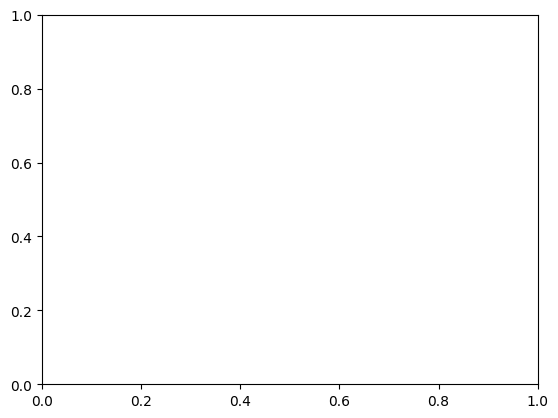

In [ ]:
qp_2 = tsp_2.to_quadratic_program()

qp2qubo = QuadraticProgramToQubo()
qubo_2 = qp2qubo.convert(qp_2)
qubitOp_2, offset_2 = qubo_2.to_ising()

exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
result_2 = exact.solve(qubo_2)

ee = NumPyMinimumEigensolver()
result_2 = ee.compute_minimum_eigenvalue(qubitOp_2)

x_2 = tsp_2.sample_most_likely(result_2.eigenstate)

z_2 = tsp_2.interpret(x_2)

adj_matrix_2 = nx.to_numpy_array(tsp_2.graph)

print("solution:", z_2)
print("solution objective:", tsp_2.tsp_value(z_2, adj_matrix_2))
colors = ["r" for node in tsp_2.graph.nodes]
#pos_2 = [tsp_2.graph.nodes[node]["pos"] for node in tsp_2.graph.nodes]
#draw_tsp_solution(tsp_2.graph, z_2, colors, pos)

In [ ]:
qp_3 = tsp_3.to_quadratic_program()

qp2qubo = QuadraticProgramToQubo()
qubo_3 = qp2qubo.convert(qp_3)
qubitOp_3, offset_3 = qubo_3.to_ising()

exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
result_3 = exact.solve(qubo_3)

ee = NumPyMinimumEigensolver()
result_3 = ee.compute_minimum_eigenvalue(qubitOp_3)

x_3 = tsp_3.sample_most_likely(result_3.eigenstate)

z_3 = tsp_3.interpret(x_3)

adj_matrix_3 = nx.to_numpy_array(tsp_3.graph)

print("solution:", z_3)
print("solution objective:", tsp_3.tsp_value(z_3, adj_matrix_3))
colors = ["r" for node in tsp_3.graph.nodes]
#pos_3 = [tsp_3.graph.nodes[node]["pos"] for node in tsp_3.graph.nodes]
#draw_tsp_solution(tsp_3.graph, z_3, colors, pos)

solution: [0, 3, 4, 2, 1]
solution objective: 119.0


In [ ]:
algorithm_globals.random_seed = 123
seed = 10598

In [ ]:
optimizer = SPSA(maxiter=300)
ry = TwoLocal(qubitOp_1.num_qubits, "ry", "cz", reps=5, entanglement="linear")
vqe = SamplingVQE(sampler=Sampler(), ansatz=ry, optimizer=optimizer)

result_1 = vqe.compute_minimum_eigenvalue(qubitOp_1)

print("energy:", result_1.eigenvalue.real)
print("time:", result_1.optimizer_time)
x_1 = tsp_1.sample_most_likely(result_1.eigenstate)
print("feasible:", qubo_1.is_feasible(x_1))
z_1 = tsp_1.interpret(x_1)
print("solution:", z_1)
print("solution objective:", tsp_1.tsp_value(z_1, adj_matrix_1))
#draw_tsp_solution(tsp.graph, z_1, colors, pos)

<ipython-input-110-d52ea7bb9150>:3: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  vqe = SamplingVQE(sampler=Sampler(), ansatz=ry, optimizer=optimizer)
